# Ground Truth masks creation, Subsets Resampling and Subset Normalizing

    The objective of this notebook falls on ground truth mask creation for each sequence of the 3 subsets. After this process, both the mask and the data sequence can be resampled for the standard dimension/size defined previously on the preprocessing notebook. The goal is to achieve Isotropic Voxelswith the intention to get input for the next stage: Training of the model

In [1]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import re
import ast
import SimpleITK as sitk
import nibabel as nib
import math

base paths and vars

In [3]:
test_path ='D:/DataOrtho/DATASET_AXIAL/24/LEFT/pd_tse_fs_tra_13/'
groundTruth_path = 'D:/DataOrtho GroundTruth'
base_path = 'D:/DataOrtho'
excel_paths = {'DATASET_AXIAL': 'D:/DataOrtho/DATASET_AXIAL/dataset_axial.xlsx', 
                            'DATASET_SAGITTAL': 'D:/DataOrtho/DATASET_SAGITTAL/dataset_sagittal.xlsx',
                            'DATASET_DYNAMIC': 'D:/DataOrtho/DATASET_DYNAMIC/dataset_dynamic.xlsx'}

subsets_metadata_paths = {'DATASET_AXIAL': 'metadata/after_validation_pixelData/axial_subset_metadata_validated.csv', 
                            'DATASET_SAGITTAL': 'metadata/after_validation_pixelData/sagittal_subset_metadata_validated.csv',
                            'DATASET_DYNAMIC': 'metadata/after_validation_pixelData/dynamic_subset_metadata_validated.csv'}

### Metadata

In [4]:
axial_landmarks = pd.read_excel(excel_paths['DATASET_AXIAL'])
axial_metadata = pd.read_csv('metadata/after_validation_pixelData/axial_subset_metadata_validated.csv')

### Visualization methods \ Help functions

#### GroundTruth and Masks creation visualization

In [63]:
#---------- 2D Visualization ----------#
# visualize mask only
def visualize_mask_of_sequence(mask,center,sigma=5):        
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='hot')
    plt.colorbar(label='Intensity')
    plt.title(f"Gaussian Mask (Center: {center}, Sigma: {sigma})")
    plt.show()
    
# visualize mri volume
def visualize_montage_mri(mri_volume, start_slice,end_slice, step=1):
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(15, 5))
    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[:,:,idx], cmap='gray')
        axarr[i].axis('off')
        axarr[i].set_title(f'Slice: {idx}')
    plt.tight_layout()
    plt.show()

#---------- 4D (channels dimension) Visualization ----------#
def plot_3d_gaussian(heatmap, threshold=0.01):
    """
    - threshold: Minimum intensity value to consider for plotting.
    """
    z, x, y = heatmap.shape
    X, Y, Z = np.mgrid[0:z, 0:x, 0:y]
    # Mask out values below the threshold
    mask = heatmap > threshold
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Y[mask], Z[mask], X[mask], c=heatmap[mask], cmap='jet', marker='o', s=5)

    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Gaussian Heatmap')
    plt.show()
    
def visualize_montage_mri_4D_channel(mri_volume,heatmaps_masks,channel, start_slice, end_slice, step=1):
    num_landmarks = heatmaps_masks.shape[-1] 
    
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(20, 5*num_landmarks))
    
    max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), heatmaps_masks[..., channel].shape)
    print(f"Channel {channel} has maximum intensity at slice: {max_intensity_idx[2]}")

    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[:, :, idx], cmap='gray')  # MRI in grayscale
        axarr[i].imshow(heatmaps_masks[:, :, idx, channel], cmap='jet', alpha=0.5)  # specific landmark heatmap overlay
        axarr[i].axis('off')
        if i == 0:
            if channel == num_landmarks - 1:
                axarr[i].set_ylabel(f'Background')
            else:
                axarr[i].set_ylabel(f'Landmark {channel + 1}')
            
        axarr[i].set_title(f'Slice: {idx}')
        
    plt.tight_layout()
    plt.show()
    
def visualize_specific_slice_4Dmask(slice_idx,channel,mri_volume, heatmaps_channel):
    fig, axarr = plt.subplots(1, figsize=(16, 8))
    axarr.imshow(mri_volume[:,:,slice_idx],cmap='gray')
    axarr.imshow(heatmaps_channel[:, :, slice_idx, channel], cmap='jet', alpha=0.5)
    axarr.set_title(f'Slice: {slice_idx}')
    plt.show()

#### Resampling visualization

In [9]:
def compare_slices_by_proportion(original_volume, resampled_volume, proportion):
    # Compute the slice index based on the proportion for both volumes
    orig_slice_idx = int(proportion * (original_volume.shape[2] - 1))
    resamp_slice_idx = int(proportion * (resampled_volume.shape[2] - 1))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the original slice
    ax1.imshow(original_volume[:, :, orig_slice_idx], cmap='gray')
    ax1.set_title('Original Volume - Slice {}'.format(orig_slice_idx))
    ax1.axis('off')
    
    # Display the resampled slice
    ax2.imshow(resampled_volume[:, :, resamp_slice_idx], cmap='gray')
    ax2.set_title('Resampled Volume - Slice {}'.format(resamp_slice_idx))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

### Important functions for mask creation

**validate_dicom_image_data** - try to read a DICOM file. Return False if there's an error, method for obtaining correct num_slices

In [6]:
def validate_dicom_image_data(file_path):
    try:
        dc = pydicom.dcmread(file_path)
        if 'PixelData' in dc:
            return True
        else:
            return False
    except:
        return False

**read_dicom_sequence** - Read a DICOM sequence from a directory: returns 3D numpy array

In [5]:
# path: directory containing DICOM files for a sequence. RESOLVER AQUELE PROBLEMA DE MULTIPLE dcm files for one sequence
def read_dicom_sequence(path):
    dicom_files = [pydicom.dcmread(os.path.join(path, f),force=True) for f in os.listdir(path) if f.endswith('.dcm') and validate_dicom_image_data(os.path.join(path, f))]
    dicom_files.sort(key=lambda x: int(getattr(x, "InstanceNumber", 99999)))
    #3D numpy array representing the MRI sequence.
    return np.stack([df.pixel_array for df in dicom_files], axis=2)

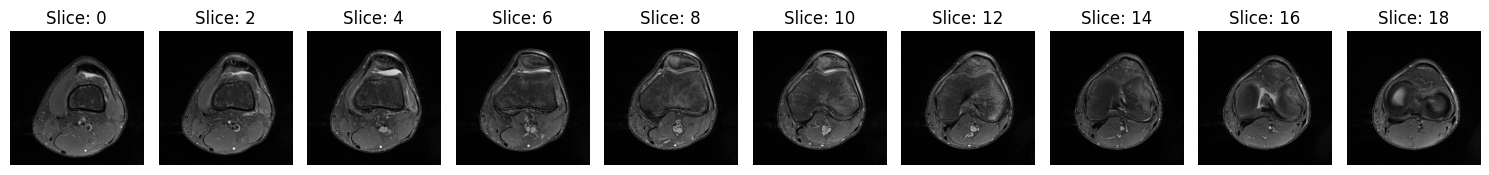

In [12]:
path_array = read_dicom_sequence(test_path)
visualize_montage_mri(path_array,0,20,step=2)

**get_sequence_properties** - Excel row matching with sequence_path: returns sequence metadata and groundtruth landmarks

In [14]:
# sequence path test of 24/LEFT/pd_tse_fs_tra_13
# return list of data from the excel
def get_sequence_properties(sequence_path,groundTruthFlag = 0):
    # define the regex pattern
    if groundTruthFlag == 0:
        pattern = r"(?P<Dataset>DATASET_\w+)[\\/](?P<Individual>\d+)[\\/](?P<Knee>LEFT|RIGHT)[\\/](?P<Sequence>[\w+]+)[\\/]*"
    
    else:
        pattern = r"(?P<Dataset>DATASET_\w+)[\\/](?P<Type>)(Masks|Volumes)[\\/](?P<Individual>\d+)[\\/](?P<Knee>LEFT|RIGHT)[\\/](?P<Sequence>[\w+]+)[\\/]*"
        
    
    # using regex pattern
    match = re.search(pattern, sequence_path)
    # matched groups as a dictionary if true
    sequence_metadata = match.groupdict()
    # dynamic on the sequence path
    excel_file_path = excel_paths[sequence_metadata.get('Dataset')]  
    
    try:
        subset_df = pd.read_excel(excel_file_path,engine='openpyxl')
        matching_rows = (subset_df["Individual"] == int(sequence_metadata.get('Individual'))) & (subset_df["Sequence"] == sequence_metadata.get('Sequence')) & (subset_df["Knee"] == sequence_metadata.get('Knee'))
        sequence_row = subset_df[matching_rows]

        landmarks = ast.literal_eval(sequence_row['Landmarks'].iloc[0])
        return sequence_metadata, landmarks
    
    except Exception as e:
            print(f"Failed to extract sequence landmarks from Excel  due to: {e}")


# Ground Truth Creation

## Gaussian Masks creation

1º **create_gaussian_mask** - Generates 2D Gaussian mask

In [13]:
# reason for reshaping y and not x is to make use of broadcasting when evaluating the Gaussian function over a 2D grid, producing a 2D Gaussian mask
def create_gaussian_mask(size, center, sigma=5):
    x = np.arange(0,size[1],1,float)
    y = np.arange(0,size[0],1,float)[:,np.newaxis]
    x0 = center[0]
    y0 = center[1]
    # numpy.ndarray
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

2º **create_gaussian_mask3D** - Generates 3D Gaussian mask spread along different slices

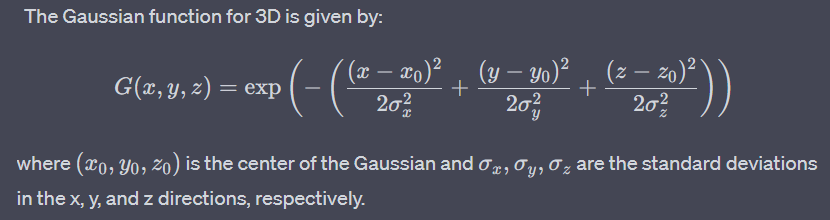

In [13]:
def create_gaussian_mask3D(size,center,sigma_x,sigma_y, sigma_z):
    x = np.arange(0, size[0], 1, float)
    y = np.arange(0, size[1], 1, float)
    # z will be the number of slices of the volume, the mask will be created on the full depth of the volume
    z = np.arange(0, size[2], 1, float)
    
    x0, y0, z0 = center
    
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    return np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2)
                    + (y - y0) ** 2 / (2 * sigma_y ** 2) 
                    + (z - z0) ** 2 / (2 * sigma_z ** 2)))

### Create all sequence mask channels

1º **create_masks_on_mri** - Volume with overlayed landmarks, Full Mask and list of Masks creation on an MRI sequence.

In [18]:
def create_masks_on_mri(sequence_path,sequence_metadata,landmarks):
    # sequence_path: directory containing DICOM files for a sequence.
    # landmarks: list of landmarks where each landmark is a tuple (x, y, landmark_index, z).
    # fetch rows e columns from csv metadata
    # to pass them to the create_gaussian_mask
    meta = ((axial_metadata['Individual'] == int(sequence_metadata['Individual'])) & (axial_metadata['Knee'] == sequence_metadata['Knee']) & (axial_metadata['Sequence'] == sequence_metadata['Sequence']))
    axial_sequence = axial_metadata[meta]
    sequence_size = [axial_sequence['Rows'].iloc[0],axial_sequence['Columns'].iloc[0]]
    try:
        # read the MRI sequence -> Create the 3D volume
        mri_sequence = read_dicom_sequence(sequence_path).astype(np.float64)
        # copy the MRI sequence for visualization and mask generation
        mri_with_landmarks = np.copy(mri_sequence)
        mask = np.zeros_like(mri_sequence)

        # we will need the number of slices too?
        # store Gaussian masks in a list
        gaussian_masks = [(landmark, create_gaussian_mask(sequence_size, (int(landmark[0]), int(landmark[1])))) for landmark in landmarks]

        # overlay landmarks on MRI for visualization
        for landmark, landmark_mask in gaussian_masks:
            x, y, _, z = landmark
            mri_with_landmarks[:, :, z] += landmark_mask

        # generate 3D mask for the model
        for landmark, landmark_mask in gaussian_masks:
            x, y, _, z = landmark
            mask[:, :, z] += landmark_mask  # add the landmark mask to the 3D volume

        # MRI with overlaid landmarks for visualization
        # 3D mask corresponding to the landmarks
        return mri_sequence, mask, gaussian_masks

    except Exception as e:
            print(f"Failed to create Mask on the MRI sequence due to: {e}")

2º **create_3Dmasks_on_mri** - MRI Volume and correspondent 3D Mask creation on an MRI sequence.

In [292]:
def create_3Dmasks_on_mri(sequence_path,sequence_metadata,landmarks):
    # fetch rows e columns from csv metadata
    # to pass them to the create_gaussian_mask
    meta = ((axial_metadata['Individual'] == int(sequence_metadata['Individual'])) & (axial_metadata['Knee'] == sequence_metadata['Knee']) & (axial_metadata['Sequence'] == sequence_metadata['Sequence']))
    axial_sequence = axial_metadata[meta]
    sequence_size = [axial_sequence['Rows'].iloc[0],axial_sequence['Columns'].iloc[0],axial_sequence['Num_Slices'].iloc[0]]
    try:
        # read the MRI sequence -> Create the 3D volume
        mri_sequence = read_dicom_sequence(sequence_path).astype(np.float64)
        # copy the MRI sequence for visualization and mask generation
        mri_with_landmarks = np.copy(mri_sequence)
        mask_3D = np.zeros_like(mri_sequence)
        # create_gaussian_mask(sequence_size, (int(landmark[0]), int(landmark[1])))
        for landmark in landmarks:
            x, y, _, z = landmark
            center = (int(x), int(y),int(z))
            gaussian_mask = create_gaussian_mask3D(sequence_size,center)
            mask_3D+= gaussian_mask
            
        mask_3D = np.clip(mask_3D,0,1)
        return mri_sequence, mask_3D
    
    except Exception as e:
        print(f"Failed to create 3D Mask on the MRI sequence due to: {e}")

3º **create_3Dmasks_on_mri_background** - introduction of the background mask

![Alt text](image.png)

Detail: the landmarks were stored with  (width,height)

In [22]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

def create_3Dmasks_on_mri_background(sequence_path,sequence_metadata,landmarks,percentageSigma):
    # fetch rows e columns from csv metadata
    # to pass them to the create_gaussian_mask
    goal_metadata = pd.read_csv(subsets_metadata_paths[sequence_metadata['Dataset']])
    
    meta = ((goal_metadata['Individual'] == int(sequence_metadata['Individual'])) & (goal_metadata['Knee'] == sequence_metadata['Knee']) & (goal_metadata['Sequence'] == sequence_metadata['Sequence']))
    sequence = goal_metadata[meta]
    sequence_size = [sequence['Rows'].iloc[0],sequence['Columns'].iloc[0],sequence['Num_Slices'].iloc[0]]
    
    try:
        sigma_x= percentage(percentageSigma,sequence_size[0])
        sigma_y = percentage(percentageSigma,sequence_size[1])
        sigma_z = percentage(percentageSigma,sequence_size[2])
    
        print('Sequence',sequence_size)
        print('sigmas:',sigma_x,sigma_y,sigma_z)
        # read the MRI sequence -> Create the 3D volume
        mri_sequence = read_dicom_sequence(sequence_path).astype(np.float64)
        #print(mri_sequence.shape)
        # heatmaps array witht the masks
        heatmaps_masks = np.zeros((*mri_sequence.shape, len(landmarks))) #(height, width, depth, N_l) 
        
        # generate the masks for each landmark
        sorted_landmarks = sorted(landmarks, key=lambda x: x[2])
        print(sorted_landmarks)
        for id, landmark in enumerate(sorted_landmarks):
            y, x, _, z = landmark # landmarks were (width,height)  
            #print(x, y, _, z)
            center = (int(x), int(y), int(z))
            gaussian_mask = create_gaussian_mask3D(sequence_size, center,sigma_x,sigma_y,sigma_z)
            heatmaps_masks[:, :, :, id] = gaussian_mask 
        
        print(heatmaps_masks)
        background_heatmap = np.ones_like(mri_sequence) - heatmaps_masks.sum(axis=-1) #(height, width, depth)
        # append the background heatmap to the 4D heatmap array
        # taking the 3D background_heatmap and adding a new axis to it to make it 4D. 
        # shape of background_heatmap:(height, width, depth), to (height, width, depth, 1).
        heatmaps_masks = np.concatenate([heatmaps_masks, background_heatmap[..., np.newaxis]], axis=-1) # (height, width, depth, N_l+1)
        
        return mri_sequence, heatmaps_masks
    
    except Exception as e:
        print(f"Failed to create 3D Mask on the MRI sequence due to: {e}")

## Single sequence Gaussian Masks creation Test

In [10]:
axial_path = 'D:/DataOrtho/DATASET_AXIAL/1/LEFT/pd_tse_fs_tra_320_3'
sagittal_path = 'D:/DataOrtho/DATASET_SAGITTAL/1/LEFT/pd_tse_fs_sag_6'
sequence_metadata,test_path_landmarks = get_sequence_properties(axial_path)

In [11]:
sequence_metadata

{'Dataset': 'DATASET_AXIAL',
 'Individual': '1',
 'Knee': 'LEFT',
 'Sequence': 'pd_tse_fs_tra_320_3'}

In [23]:
mri_volume, masks = create_3Dmasks_on_mri_background(sagittal_path,sequence_metadata,test_path_landmarks,5)

Sequence [320, 300, 30]
sigmas: 16.0 15.0 1.5
Failed to create 3D Mask on the MRI sequence due to: name 'sorted_landmarksed' is not defined


TypeError: cannot unpack non-iterable NoneType object

In this test path landmarks there are:

- 2 lm: slice 6
- 5 lm: slice 11
- 2 lm: slice 20
- 1 lm: slice 19
- 1 lm: slice 27

Channel 0 has maximum intensity at slice: 6


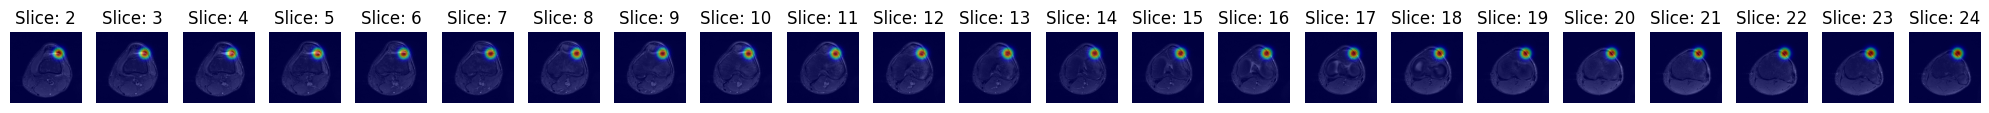

In [33]:
visualize_montage_mri_4D_channel(mri_volume,masks,0,2,25)

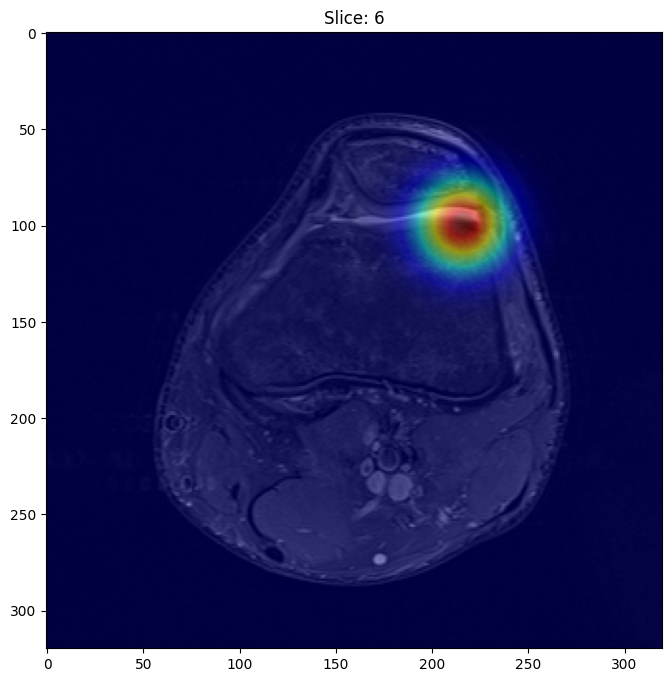

In [36]:
# 216.06797575754285 99.45091804199295
visualize_specific_slice_4Dmask(6,0,mri_volume,masks)

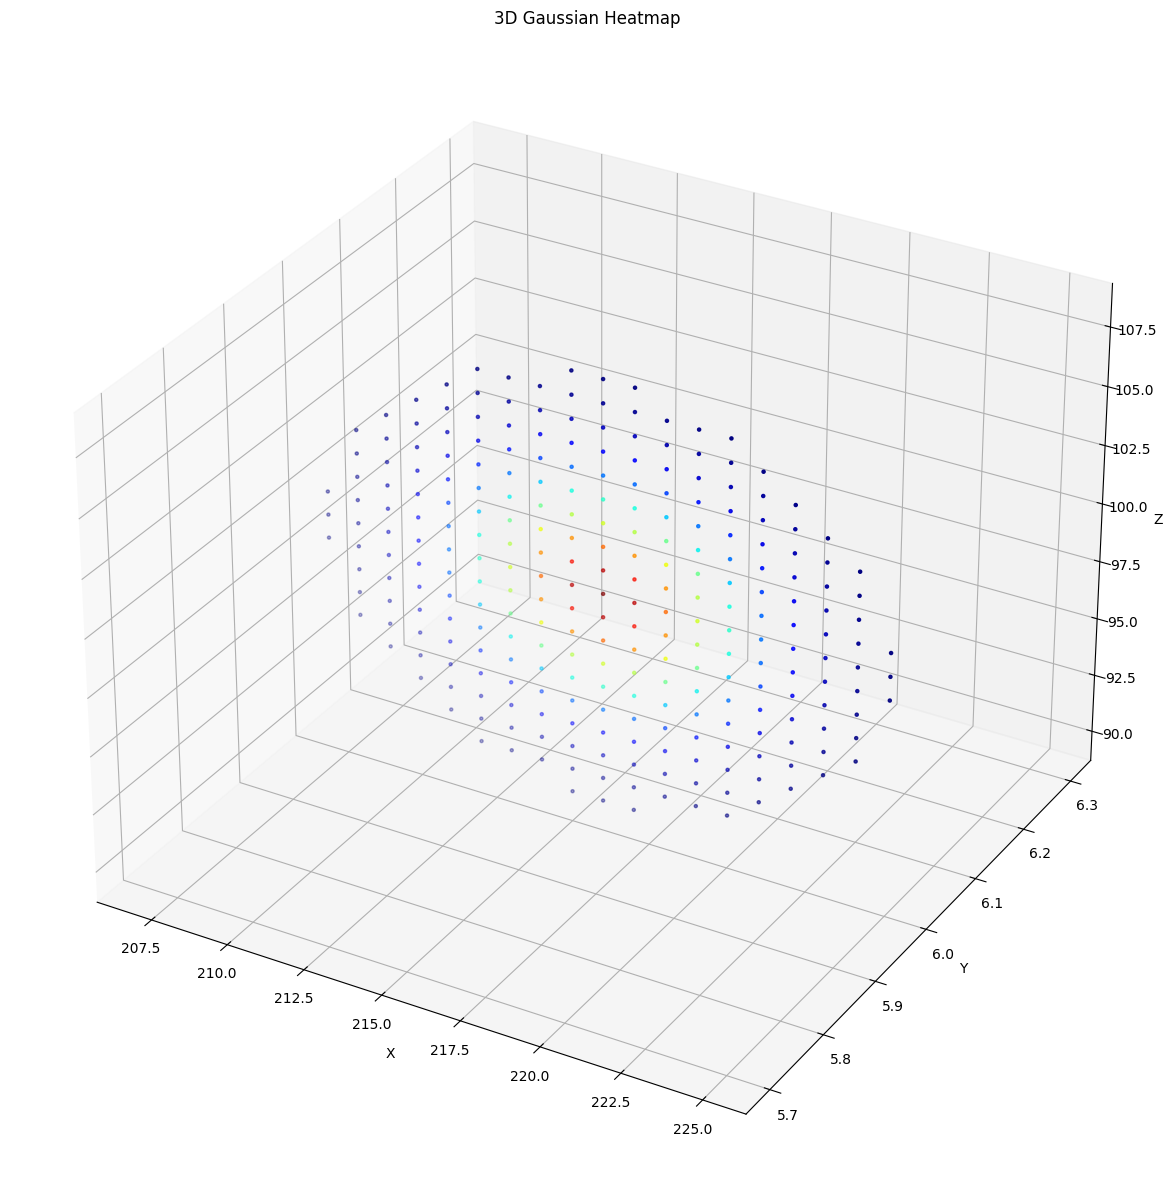

In [26]:
# Example:
size = [320, 320, 30]
center = [99, 216, 6]
heatmap = create_gaussian_mask3D(size, center, sigma_xy=10, sigma_z=0.03)
plot_3d_gaussian(heatmap)

## Ground Truth Masks creation

    Mask creation for an entire subset, through the use of the previous implemented functions:
    - Get metadata 
    - Get landmarks
    - Create masks
    - Save them masks

Neuroimaging Informatics Technology Initiative (NIfTI format)  [.nii or .nii.gz]

- Format is widely used in medical imaging. 
- Allows storage of metadata along with the 3D volume data.
- nibabel librarie can be used to save and load NIfTI files in Python.

**save_mask_nifti** - save 3D volume data into file, 3D volume or correspondent mask

In [14]:
def save_volume_nifti(data, file):
    # no transformation, so we use identity matrix: eye method
    img = nib.nifti1.Nifti1Image(data,np.eye(4)) # after reampling what happens?
    img.to_filename(file)
    

**read_nifti_sequence** - returns the np.ndarray of both volume and masks nifti file associated with the sequence. Used for resampling task

In [15]:
def read_nifti_sequence(volume_path, masks_path):
    # read image from the vol and mask path
    sitk_volume = sitk.ReadImage(volume_path)
    sitk_masks = sitk.ReadImage(masks_path)
    # get array from each
    volume = sitk.GetArrayFromImage(sitk_volume)
    masks= sitk.GetArrayFromImage(sitk_masks)

    # shape does not come as in numpy, simpleITK uses a different convention for image axes than numpy does so transpose in necessary
    # if we not running on the resampling_sequence
    #volume = np.transpose(volume)
    #masks= np.transpose(masks)
    
    return volume,masks

**ensure_directory_exists** - verification if dir exists, if not then create one

In [16]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

**create_masks_subset** - creation of full mask volumes for a subset: AXIAL, SAGITTAL or DYNAMIC

In [56]:
def create_masks_subset(subset_path,subset_path_gt):
    total_sequences = 0  
    if os.path.isdir(subset_path):
        # individuals
        for individual in os.listdir(subset_path):
            individual_path = os.path.join(subset_path, individual)
            
            individual_path_gt_volumes = os.path.join(subset_path_gt,'Volumes',individual)
            individual_path_gt_masks = os.path.join(subset_path_gt,'Masks',individual)
            # if not existent create them dirs
            #ensure_directory_exists(individual_path_gt_volumes)
            #ensure_directory_exists(individual_path_gt_masks)
            if os.path.isdir(individual_path):
                # knees
                for knee in os.listdir(individual_path):
                    knee_path = os.path.join(individual_path, knee)
                    # sequences
                    for sequence in os.listdir(knee_path):
                        sequence_path = os.path.join(knee_path, sequence)
                        try:
                            # sequence metadata and respective landmarks for mask creation
                            sequence_metadata,test_path_landmarks = get_sequence_properties(sequence_path)
                            # MRI volume with the landmarks overlaid for visualization purposes, 3D mask for the volume and mask list for debug
                            mri_sequence, mask3D = create_3Dmasks_on_mri_background(sequence_path,sequence_metadata,test_path_landmarks,5)
                            
                            # save paths for both volume and mask
                            save_path_volume = os.path.join(individual_path_gt_volumes, knee, sequence, sequence + ".nii")
                            save_path_mask = os.path.join(individual_path_gt_masks, knee, sequence, sequence + "_mask.nii.gz")
                            
                            #save both 3D volumes, mri and correspondent mask
                            save_volume_nifti(mri_sequence, save_path_volume)
                            save_volume_nifti(mask3D, save_path_mask)
                            
                            total_sequences += 1
                        except Exception as e:
                            print(f"Failed to create Masks and Volume on the MRI sequence {sequence_path} due to: {e}")
                            
    print('Total created mask Sequences: ', total_sequences)
                                                  

**create_groundTruth** - main function to create ground Truth Mask for all subsets

In [57]:
def create_groundTruth(path):
    # subsets
    for subset in os.listdir(path):
        subset_path = os.path.join(path, subset)
        create_masks_subset(path,subset_path)

**clean_subset_groundTruth** - function to clean specific subset ground Truth Mask. CHANGE ACCORDINGLY

In [19]:
def clean_subset_groundTruth(subset_path_gt):
    
    if os.path.isdir(subset_path_gt):
        # Volumes and Masks directories
        ground_truth_cleaned = 0
        volumes_masks_paths = [os.path.join(subset_path_gt, 'Volumes'), os.path.join(subset_path_gt, 'Masks')]
        for path  in volumes_masks_paths:
            if os.path.isdir(path):
                # individuals
                for individual in os.listdir(path):
                    individual_path = os.path.join(path, individual)
                    if os.path.isdir(individual_path):                               
                        # knees
                        for knee in os.listdir(individual_path):
                            knee_path = os.path.join(individual_path, knee)
                            # sequences
                            for sequence in os.listdir(knee_path):
                                sequence_path = os.path.join(knee_path,sequence)
                                for file in os.listdir(sequence_path):
                                    if file.endswith('.gz') or file.endswith('.nii'):
                                        file_path = os.path.join(sequence_path,file)
                                        os.remove(file_path)
                                        ground_truth_cleaned += 1
    print(ground_truth_cleaned)

## Ground Truth creation Test - Subset Axial/Sagittal/Dynamic 

In [58]:
axial_path = 'D:/DataOrtho/DATASET_AXIAL/'
axial_path_gt = 'D:/DataOrtho GroundTruth/DATASET_AXIAL'

### Sagittal

In [81]:
sagittal_path = 'D:/DataOrtho/DATASET_SAGITTAL/'
sagittal_path_gt = 'D:/DataOrtho GroundTruth/DATASET_SAGITTAL'

In [59]:
create_masks_subset(sagittal_path,sagittal_path_gt)

Total created mask Sequences:  429


In [60]:
sagittal_path_volume = 'D:/DataOrtho GroundTruth/DATASET_SAGITTAL/Volumes/1/LEFT/pd_tse_fs_sag_6/pd_tse_fs_sag_6.nii'
sagittal_path_masks = 'D:/DataOrtho GroundTruth/DATASET_SAGITTAL/Masks/1/LEFT/pd_tse_fs_sag_6/pd_tse_fs_sag_6_mask.nii.gz'

In [61]:
sagittal_volume, sagittal_mask = read_nifti_sequence(sagittal_path_volume,sagittal_path_masks) 

In [65]:
sagittal_volume.shape

(25, 320, 320)

In [69]:
sagittal_mask.shape

(8, 25, 320, 320)

In [70]:
sagittal_volume = np.transpose(sagittal_volume)
sagittal_mask= np.transpose(sagittal_mask)

Channel 2 has maximum intensity at slice: 12


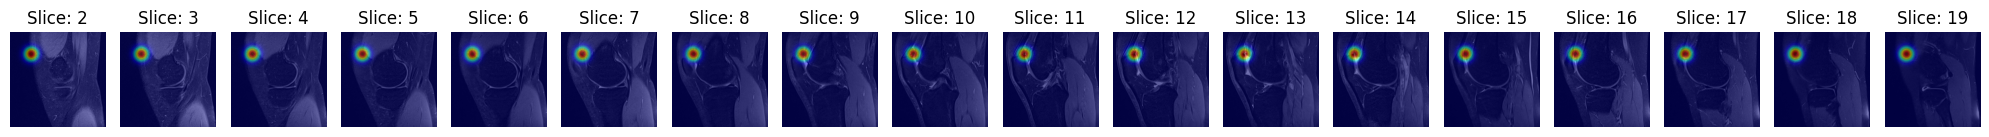

In [74]:
visualize_montage_mri_4D_channel(sagittal_volume,sagittal_mask,2,2,20)

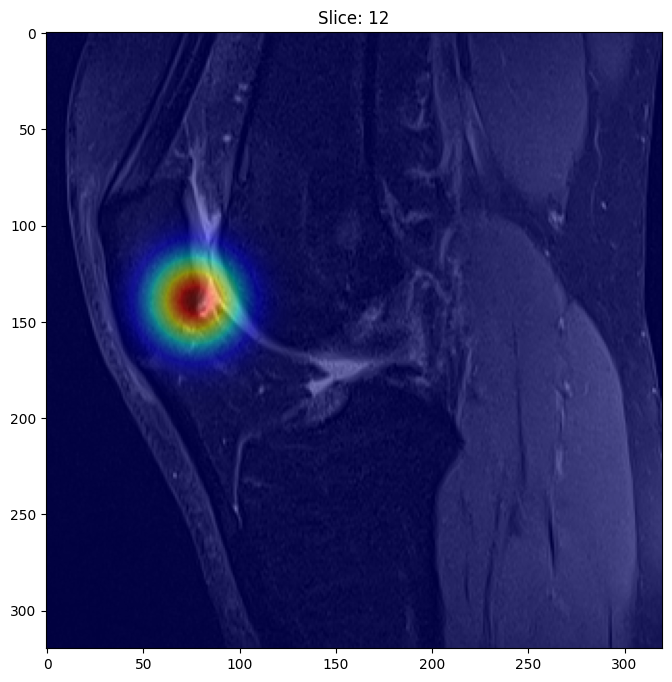

In [77]:
visualize_specific_slice_4Dmask(12,3,mri_volume,masks)

### Dynamic

In [80]:
dynamic_path = 'D:/DataOrtho/DATASET_DYNAMIC/'
dynamic_path_gt = 'D:/DataOrtho GroundTruth/DATASET_DYNAMIC'

In [82]:
create_masks_subset(dynamic_path,dynamic_path_gt)

Total created mask Sequences:  330


# Resampling

## Resampling method
    Resample all volumes and masks created at Ground Truth creation step with the desired size and save the resampled outcome into Resampled path.

References:
https://simpleitk.readthedocs.io/en/master/IO.html

### Resample vars: goal spacing for each subset

In [86]:
list_size = {'DATASET_AXIAL': [320,320,30], 
                            'DATASET_SAGITTAL': [320,320,25],
                            'DATASET_DYNAMIC': [320,160,72]}

resampled_path_axial_linear = 'D:/DataOrtho Resampled/Linear Interpolation/DATASET_AXIAL'
axial_path_gt = 'D:/DataOrtho GroundTruth/DATASET_AXIAL'

resampled_path_sagittal_linear = 'D:/DataOrtho Resampled/Linear Interpolation/DATASET_SAGITTAL'
sagittal_path_gt = 'D:/DataOrtho GroundTruth/DATASET_SAGITTAL'

resampled_path_dynamic_linear = 'D:/DataOrtho Resampled/Linear Interpolation/DATASET_DYNAMIC'
dynamic_path_gt = 'D:/DataOrtho GroundTruth/DATASET_DYNAMIC'

**resample_sequence** - Resample the DICOM volume and the correspondent ground truth at the given volume and masks path to a new spacing. Using sitk library to load the .nii and .nii.gz files 


In [84]:
def resample_sequence(volume_path,masks_path,desired_size, interpolator=sitk.sitkLinear):
    # interpolator (SimpleITK interpolator, optional) - interpolation method to use, default being sitk.sitkLinear
    volume, masks = read_nifti_sequence(volume_path,masks_path)
    
    # volume resample , simple 3D volume resampling
    # create the sitk image from np array volume, where we get the correspondent metadata to create the new_size and to fill Exceute call
    sitk_volume = sitk.GetImageFromArray(volume)
    
    # filter
    resampler = sitk.ResampleImageFilter()
    orig_spacing = sitk_volume.GetSpacing()
    orig_size = sitk_volume.GetSize()
    # computation new size based on the desired new_spacing  
    # Compute new spacing based on desired size while maintaining the physical size
    new_spacing = [orig_spacing[i] * (orig_size[i] / desired_size[i]) for i in range(3)]
    
    # debug 
    #print("Original Spacing:", orig_spacing)
    #print("Original Size:", orig_size)
    #print("Desired Spacing:", new_spacing)
    #print("Computed New Size:", desired_size)
    
    # using linear interpolation
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(desired_size)
    resampler.SetOutputDirection(sitk_volume.GetDirection())
    resampler.SetOutputOrigin(sitk_volume.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0)
    
    # Resample the volume
    resampled_volume = resampler.Execute(sitk_volume)
    resampled_volume = sitk.GetArrayFromImage(resampled_volume)
    # since the shape of mask is  (height,width,depth,n_channels) we are going to resample a 4D Mask 
    # with sitk.ReadImage not just reading the pixel/voxel values but also the associated metadata. 
    # metadata includes important information like the origin, spacing, and direction of the image.    
    # SimpleITK and numpy have different conventions for image axes, we must return and work with the correct axes
    
    n_channels = masks.shape[0]
    resampled_masks = []
    for i in range(n_channels):
        sitk_mask_channel = sitk.GetImageFromArray(masks[i,...])
        resampled_mask_channel = resampler.Execute(sitk_mask_channel)
        resampled_masks.append(sitk.GetArrayFromImage(resampled_mask_channel))
    
    resampled_masks = np.stack(resampled_masks,axis=-1)
    resampled_volume = np.transpose(resampled_volume)
    

    # first axis (0) of resampled_masks is depth (30), which should be the third axis in the desired shape.
    # second axis (1) is height (320), which should remain as the first axis.
    # third axis (2) is width (320), which should be the second axis.
    # fourth axis (3) is the channels (depending on the typoe of dataset), which should remain as the fourth axis.
    resampled_masks = np.transpose(resampled_masks, (2, 1, 0, 3))
    
    return resampled_volume, resampled_masks
    

**resample_subset** - resample function called for each sequence in the Axial subset

In [85]:
# I need to the files that are on ground truth 
# and resample those paths and save into resampled path

# Read from: 2 paths
# GROUNDTRUTH - SUBSET - TYPE (MASK|VOLUMES) - INDIVIDUAL

# Save into: 2 paths
# RESAMPLED - LINEAR - SUBSET - TYPE (MASK|VOLUMES) - INDIVIDUAL

def resample_subset(resampled_path,subset_path, interpolatorFlag):
    # resampled_path already interpolation and subset folder
    total_resampled = 0
    if not os.path.isdir(subset_path):
        print(f"Error: {subset_path} is not a directory!")
        return
    
    if interpolatorFlag == 0:
        interpolator= sitk.sitkLinear
    else:
        interpolator = sitk.sitkNearestNeighbor
    # Volumes and Mask directory

    gt_path_volumes = os.path.join(subset_path, 'Volumes')
    resampled_path_volume = os.path.join(resampled_path, 'Volumes')
    
    gt_path_masks = os.path.join(subset_path, 'Masks')
    resampled_path_masks = os.path.join(resampled_path, 'Masks')

    ensure_directory_exists(resampled_path_volume)
    ensure_directory_exists(resampled_path_masks)
    
    for individual in os.listdir(gt_path_volumes):
        individual_gt_volumes = os.path.join(gt_path_volumes, individual)
        individual_resampled_volumes = os.path.join(resampled_path_volume, individual) 
        
        individual_gt_masks = os.path.join(gt_path_masks,individual)
        individual__resampled_masks = os.path.join(resampled_path_masks,individual)
        
        
        for knee in os.listdir(individual_gt_volumes):
            knee_gt_volumes = os.path.join(individual_gt_volumes, knee)
            knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
            
            knee_gt_masks = os.path.join(individual_gt_masks, knee)
            knee_resampled_masks = os.path.join(individual__resampled_masks, knee)
            #ensure_directory_exists(knee_resampled_path)

            #sequences
            for sequence in os.listdir(knee_gt_volumes):  
                sequence_gt_volume= os.path.join(knee_gt_volumes, sequence)
                sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                
                sequence_gt_masks = os.path.join(knee_gt_masks, sequence)
                sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                    
                for file in os.listdir(sequence_gt_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            sequence_metadata, _ = get_sequence_properties(sequence_gt_volume,1)
                            desired_size = list_size[sequence_metadata.get('Dataset')]
                            volume_gt_path = os.path.join(sequence_gt_volume,file)
                            masks_gt_path = os.path.join(sequence_gt_masks,sequence + "_mask.nii.gz") 
                            resampled_volume, resampled_masks = resample_sequence(volume_gt_path,masks_gt_path,desired_size,interpolator)
                            #print('Resampling: ', volume_gt_path, masks_gt_path)
                            
                            # save paths for both volume and mask
                            save_path_resampled_volume = os.path.join(sequence_resampled_volume,sequence +".nii.gz")
                            save_path_resampled_masks = os.path.join(sequence_resampled_masks, sequence + "_mask.nii.gz")
                            #print('Saving resampled into: ', save_path_resampled_volume, save_path_resampled_masks)
                            
                            #save both 3D volumes, mri and correspondent mask
                            save_volume_nifti(resampled_volume, save_path_resampled_volume)
                            save_volume_nifti(resampled_masks, save_path_resampled_masks)
                            total_resampled+=1
                        except Exception as e:
                            print(f"Exception made on resample_subset! Failed to resample the sequence {sequence_gt_volume} due to: {e}")
    print(f"Total resampled sequences: {total_resampled}")


Axial Resample

In [47]:
resample_subset(resampled_path_axial_linear,axial_path_gt, 0)

Total resampled sequences: 234


Sagittal Resample

In [ ]:
resample_subset(resampled_path_sagittal_linear,sagittal_path_gt, 0)

Dynamic Resample

In [ ]:
resample_subset(resampled_path_dynamic_linear,dynamic_path_gt, 0)

### Resample of whole Ground Truth

**resample_groundTruth** - going to be traversed through the Ground Truth directory

In [314]:
def resample_groundTruth(resample_path,gtruth_path,interpolationFlag):
    if interpolationFlag == 0:
        interpolation ='Linear Interpolation'.rstrip()
    else: 
        interpolation = 'Nearest Neighbours'.rstrip()
    interpolation_path = os.path.join(resample_path, interpolation)
    for subset in os.listdir(interpolation_path):
        subset_path = os.path.join(interpolation_path, subset)
        subset_gt_path = os.path.join(gtruth_path, subset)
        resample_subset(subset_path,subset_gt_path,interpolationFlag)  
        
        
#resample_groundTruth('D:/DataOrtho Resampled/','D:/DataOrtho GroundTruth',0)

## Simple sequence Resampling Test - Subset Axial

In [283]:
# DATASET_AXIAL,67,RIGHT,AXIAL_DP_FS_MTC_4,38,3.0,3.3,"[0.446429, 0.446429]",336,336,0.446429,0.446429,True HIGHER NUM_SLICES
test_res_path_1 = ['D:/DataOrtho/DATASET_AXIAL/67/RIGHT/AXIAL_DP_FS_MTC_4', 'D:/DataOrtho GroundTruth/DATASET_AXIAL/Volumes/67/RIGHT/AXIAL_DP_FS_MTC_4/AXIAL_DP_FS_MTC_4.nii', 'D:/DataOrtho GroundTruth/DATASET_AXIAL/Masks/67/RIGHT/AXIAL_DP_FS_MTC_4/AXIAL_DP_FS_MTC_4_mask.nii.gz']
# DATASET_AXIAL,22,RIGHT,t1_tse_tra_21,26,3.0,3.9,"[0.322265625, 0.322265625]",512,416,0.322265625,0.322265625,True LOWER NUM_SLICES
test_res_path_2 = ['D:/DataOrtho/DATASET_AXIAL/22/RIGHT/t1_tse_tra_21', 'D:/DataOrtho GroundTruth/DATASET_AXIAL/Volumes/22/RIGHT/t1_tse_tra_21/t1_tse_tra_21.nii', 'D:/DataOrtho GroundTruth/DATASET_AXIAL/Masks/22/RIGHT/t1_tse_tra_21/t1_tse_tra_21.nii.gz']

### Test 1 with more slices

In [285]:
# get only row of the dataseries , use iloc for df and panda series work
test_res_path_1_metadata,test_res_path_1_landmarks = get_sequence_properties(test_res_path_1[0])
test_res_path_1_volume, test_res_path_1_masks = create_3Dmasks_on_mri_background(test_res_path_1[0],test_res_path_1_metadata,test_res_path_1_landmarks,5)
save_volume_nifti(test_res_path_1_volume, test_res_path_1[1])
save_volume_nifti(test_res_path_1_masks, test_res_path_1[2])

87.98836973939777 97.12763758544403 1 8
91.6440768778163 147.69825300023317 2 8
225.686671953161 104.43905186228099 3 11
226.90524099930053 217.76597315325432 4 11
84.94194712404902 92.86264592395577 5 11
95.9090685393045 157.44680536934916 6 11
84.33266260097926 183.64603986134836 7 11
223.85881838395179 108.70404352376922 8 23
234.82593979920725 176.3346255845114 9 23
220.20311124553328 169.0232113076744 10 21
95.29978401623472 128.20114826200123 11 30


Channel 0 has maximum intensity at slice: 8


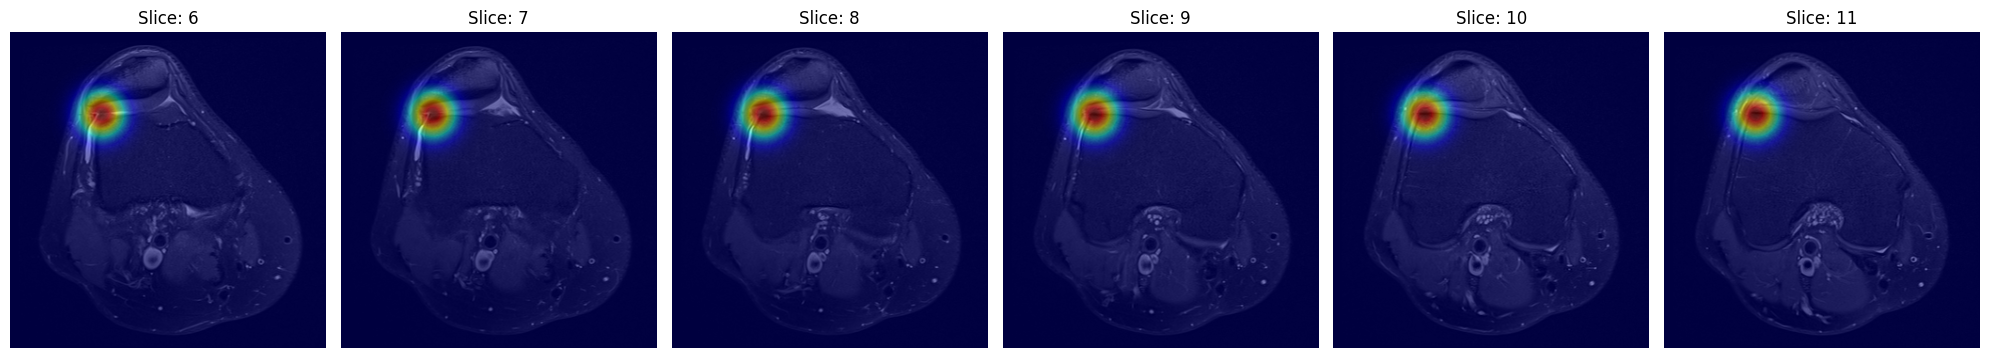

In [286]:
visualize_montage_mri_4D_channel(test_res_path_1_volume,test_res_path_1_masks,0,6,12)

In [287]:
print(test_res_path_1_volume.shape)
print(test_res_path_1_masks.shape[-1])

(336, 336, 38)
12


In [142]:
# both these onjects come with changed axis, need to be transposed to be visualized
volume, mask = read_nifti_sequence(test_res_path_1[1],test_res_path_1[2])

In [149]:
resampled_volume, resampled_masks = resample_sequence(test_res_path_1[1],test_res_path_1[2],list_size['DATASET_AXIAL'])

Original Spacing: (1.0, 1.0, 1.0)
Original Size: (336, 336, 38)
Desired Spacing: [1.05, 1.05, 1.2666666666666666]
Computed New Size: [320, 320, 30]


In [150]:
print(resampled_volume.shape)
print(resampled_masks.shape)

(320, 320, 30)
(320, 320, 30, 12)


Smoother images

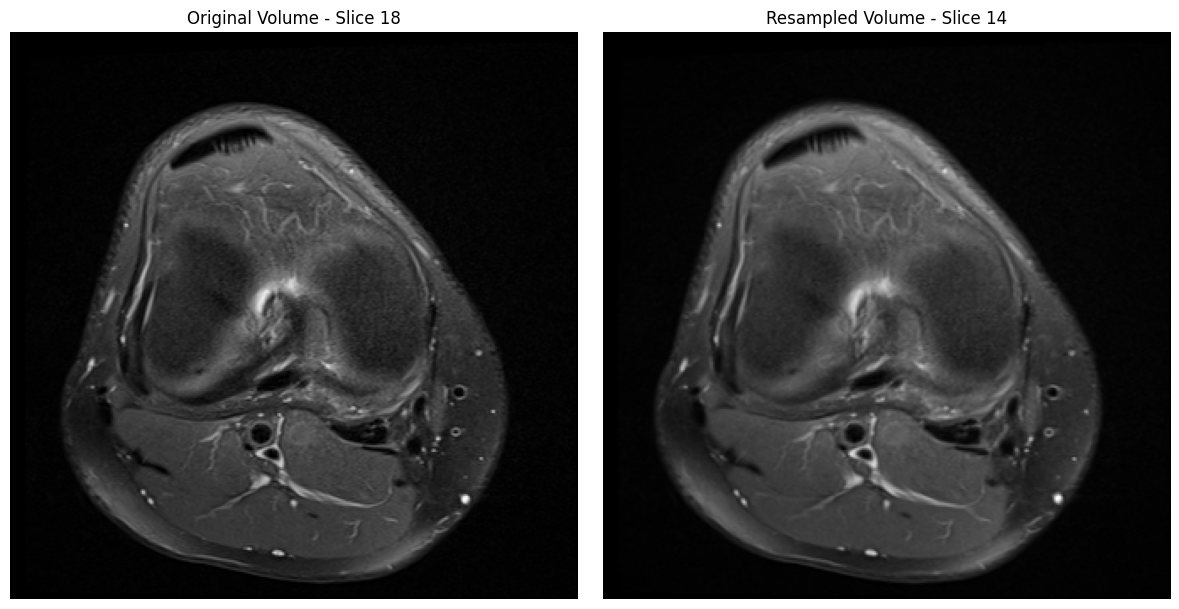

In [156]:
volume = np.transpose(volume)
proportion = 0.5  # Choose any proportion between 0 and 1
compare_slices_by_proportion(volume, resampled_volume, proportion)

Channel 0 has maximum intensity at slice: 6


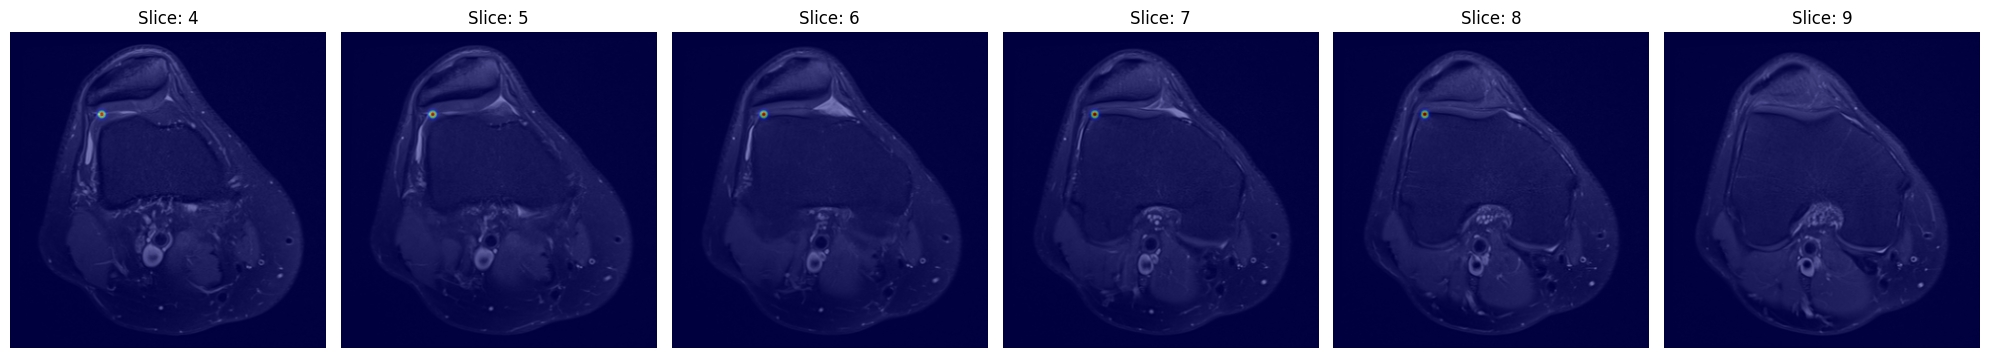

In [163]:
visualize_montage_mri_4D_channel(resampled_volume,resampled_masks,0,4,10)

### Test 2 with less slices

In [293]:
test_res_path_2_metadata,test_res_path_2_landmarks = get_sequence_properties(test_res_path_2[0])
test_res_path_2_volume, test_res_path_2_masks = create_3Dmasks_on_mri_background(test_res_path_2[0],test_res_path_2_metadata,test_res_path_2_landmarks,5)
save_volume_nifti(test_res_path_2_volume, test_res_path_2[1])
save_volume_nifti(test_res_path_2_masks, test_res_path_2[2])

(512, 416, 26)
146.71203189166152 113.95081341656501 1 5
133.16644831396962 172.3661425953615 2 5
318.5716235336281 120.72360520541102 3 7
319.41822250723385 243.48045637824424 4 7
140.78583907642133 150.35456928161213 5 7
146.71203189166152 185.06512719944766 6 7
141.63243805002708 201.99710667156262 7 7
327.0376132696856 145.2749754399776 8 16
321.958019428051 224.85527895891784 9 16
310.1056337975706 212.15629435483157 10 15
176.3429959678627 110.56441752214204 11 23


Channel 1 has maximum intensity at slice: 5


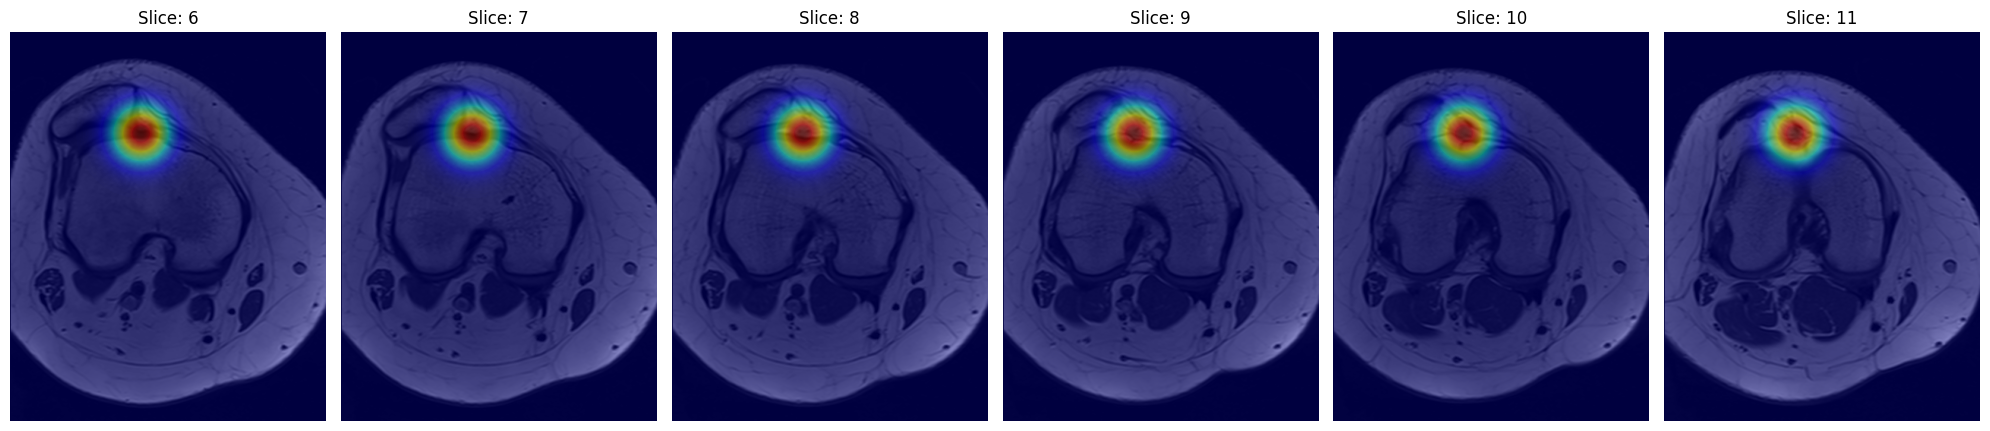

In [295]:
visualize_montage_mri_4D_channel(test_res_path_2_volume,test_res_path_2_masks,1,6,12)

In [297]:
print(test_res_path_2_volume.shape)
print(test_res_path_2_masks.shape)
# both these onjects come with changed axis, need to be transposed to be visualized


(512, 416, 26)
(512, 416, 26, 12)


In [301]:
# both these onjects come with changed axis, need to be transposed to be visualized
volume2, masks2 = read_nifti_sequence(test_res_path_2[1],test_res_path_2[2])

In [300]:
volume, mask = read_nifti_sequence(test_res_path_2[1],test_res_path_2[2])
resampled_volume2, resampled_masks2 = resample_sequence(test_res_path_2[1],test_res_path_2[2],list_size['DATASET_AXIAL'])
print(resampled_volume2.shape)
print(resampled_masks2.shape)

(1.0, 1.0, 1.0)
Original Spacing: (1.0, 1.0, 1.0)
Original Size: (512, 416, 26)
Desired Spacing: [1.6, 1.3, 0.8666666666666667]
Computed New Size: [320, 320, 30]
(320, 320, 30)
(320, 320, 30, 12)


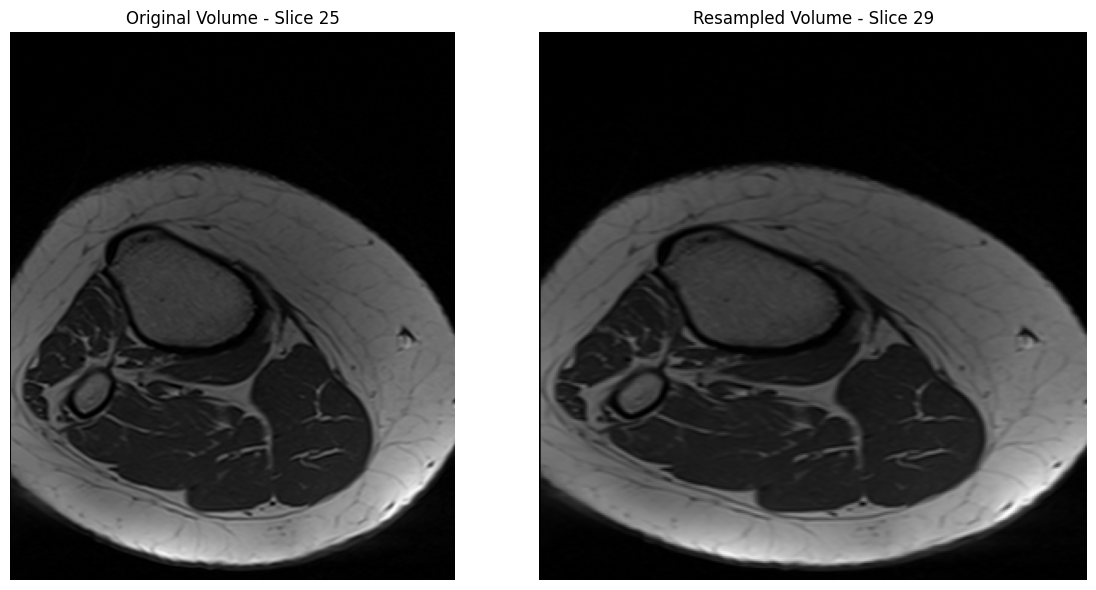

In [305]:
volume2 = np.transpose(volume2)
proportion = 0.5  # Choose any proportion between 0 and 1
compare_slices_by_proportion(volume2, resampled_volume2, proportion)

Trying to compare normal and resampled slices with designed channel of heatmaps

In [ ]:
def overlay_mask_on_slice(volume_slice, mask_slice, mask_color=[255, 0, 0]):
    """
    Overlay the mask on the volume slice.
    
    Parameters:
    - volume_slice: 2D slice from the volume
    - mask_slice: 2D slice from the mask (same size as volume_slice)
    - mask_color: RGB color for the mask. Default is red ([255, 0, 0]).
    
    Returns:
    - overlay: RGB image with mask overlaid on the volume slice
    """
    overlay = np.zeros((volume_slice.shape[0], volume_slice.shape[1], 3))
    for ch in range(3):  # for each channel (R, G, B)
        overlay[..., ch] = volume_slice * (1 - mask_slice) + mask_color[ch] * mask_slice
    return overlay.astype(np.uint8)

def compare_slices_by_proportion_with_mask(original_volume, resampled_volume, original_mask, resampled_mask, proportion):
    orig_slice_idx = int(proportion * (original_volume.shape[2] - 1))
    resamp_slice_idx = int(proportion * (resampled_volume.shape[2] - 1))
    
    orig_overlay = overlay_mask_on_slice(original_volume[:, :, orig_slice_idx], original_mask[:, :, orig_slice_idx])
    resamp_overlay = overlay_mask_on_slice(resampled_volume[:, :, resamp_slice_idx], resampled_mask[:, :, resamp_slice_idx])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(orig_overlay, cmap='gray')
    ax1.set_title('Original Volume - Slice {}'.format(orig_slice_idx))
    ax1.axis('off')
    
    ax2.imshow(resamp_overlay, cmap='gray')
    ax2.set_title('Resampled Volume - Slice {}'.format(resamp_slice_idx))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
compare_slices_by_proportion_with_mask(volume2, resampled_volume2, masks2, resampled_masks2, 0.5)


## DIVIDIR TREINO/TESTE

# Normalizing

Min-Max Scaling:
- Compute the min and max for each volume
- Overall min is the minimum of these mins, and the overall max is the maximum of these maxes.




In [12]:
# Read Resample path and the respective interpolation
axial_path_gt_volumes = 'D:/DataOrtho GroundTruth/DATASET_AXIAL/Volumes'
sagittal_path_gt_volumes = 'D:/DataOrtho GroundTruth/DATASET_SAGITTAL/Volumes'
dynamic_path_gt_volumes = 'D:/DataOrtho GroundTruth/DATASET_DYNAMIC/Volumes'

In [2]:
def normalize_volume_minmax(volume,min_val,max_val):
    return (volume - min_val) / (max_val - min_val)

In [13]:
# this time using nib, iterate through gt path to find min/max
def compute_subset_minmax(subset_volumes_path):
    mins = []
    maxs = []
    for individual in os.listdir(subset_volumes_path):
        individual_path = os.path.join(subset_volumes_path, individual)
        # if not existent create them dirs
        if os.path.isdir(individual_path):
            # knees
            for knee in os.listdir(individual_path):
                knee_path = os.path.join(individual_path, knee)
                # sequences
                for sequence in os.listdir(knee_path):
                    sequence_path = os.path.join(knee_path, sequence)
                    for file in os.listdir(sequence_path):
                        if file.endswith('.nii'):
                            file_path = os.path.join(sequence_path,file)
                            volume = nib.load(file_path).get_fdata()
                            mins.append(np.min(volume))
                            maxs.append(np.max(volume))
                            
    overall_min = np.min(mins)
    overall_max = np.max(maxs)
    return overall_min, overall_max
        

In [ ]:
normalization_values = {'DATASET_AXIAL': [compute_subset_minmax(axial_path_gt_volumes)], 
                            'DATASET_SAGITTAL': [compute_subset_minmax(sagittal_path_gt_volumes)],
                            'DATASET_DYNAMIC': [compute_subset_minmax(dynamic_path_gt_volumes)]}

In [14]:
overall_min, overall_max = compute_subset_minmax(axial_path_gt_volumes)

In [15]:
print(overall_min,overall_max)

0.0 2898.0


In [ ]:
# Save into: 2 paths
# -----------INPUT-----------
# RESAMPLED - LINEAR - SUBSET - TYPE (MASK|VOLUMES) - INDIVIDUAL

def normalize_subset(resampled_path,subset):
    # resampled_path already interpolation and subset folder
    total_volumes_normalized = 0
    if not os.path.isdir(resampled_path):
        print(f"Error: {resampled_path} is not a directory!")
        return
    # Volumes and Mask directory
    resampled_path_volume = os.path.join(resampled_path, 'Volumes')
    resampled_path_masks = os.path.join(resampled_path, 'Masks')

    ensure_directory_exists(resampled_path_volume)
    ensure_directory_exists(resampled_path_masks)
    
    for individual in os.listdir(resampled_path_volume):
        individual_resampled_volumes = os.path.join(resampled_path_volume, individual) 
        individual__resampled_masks = os.path.join(resampled_path_masks,individual)
        for knee in os.listdir(individual_resampled_volumes):
            knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
            knee_resampled_masks = os.path.join(individual__resampled_masks, knee)
            #ensure_directory_exists(knee_resampled_path)
            #sequences
            for sequence in os.listdir(knee_resampled_volumes):  
                sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                for file in os.listdir(sequence_resampled_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            #OVERWRITE THE .nii and _mask.nii
                            norm_values = normalization_values[subset]
                            volume_nii = nib.load(file)
                            normalized_volume = normalize_volume_minmax(volume_nii,norm_values[0],norm_values[1])                            
                            # save paths for both volume and mask
                            save_path_resampled_volume = os.path.join(sequence_resampled_volume,sequence +".nii.gz")
                            #save normalized mri volume
                            save_volume_nifti(normalized_volume, save_path_resampled_volume)
                            total_volumes_normalized+=1
                        except Exception as e:
                            print(f"Exception made on resample_subset! Failed to resample the sequence {sequence_resampled_volume} due to: {e}")
    print(f"Total resampled sequences: {total_volumes_normalized}")

In [ ]:
def normalize_groundTruth(resample_path,interpolationFlag):
    if interpolationFlag == 0:
        interpolation ='Linear Interpolation'.rstrip()
        
    else: 
        interpolation = 'Nearest Neighbours'.rstrip()
    interpolation_path = os.path.join(resample_path, interpolation)
    for subset in os.listdir(interpolation_path):
        res_subset_path = os.path.join(interpolation_path, subset)
        normalize_subset(res_subset_path,subset)